In [1]:
import numpy as np
import pickle
import tensorflow as tf
import sys
sys.path.append("/home/ritchie46/code/python/anaStruct")

from anastruct.fem.system import SystemElements
import matplotlib.pyplot as plt
%matplotlib inline
import math


/home/ritchie46/code/python/anaStruct/anastruct/fem/plotter.py:10: UserWarning: Plotly not found. The functions that require plotly will result in an error
  warnings.warn("Plotly not found. The functions that require plotly will result in an error")


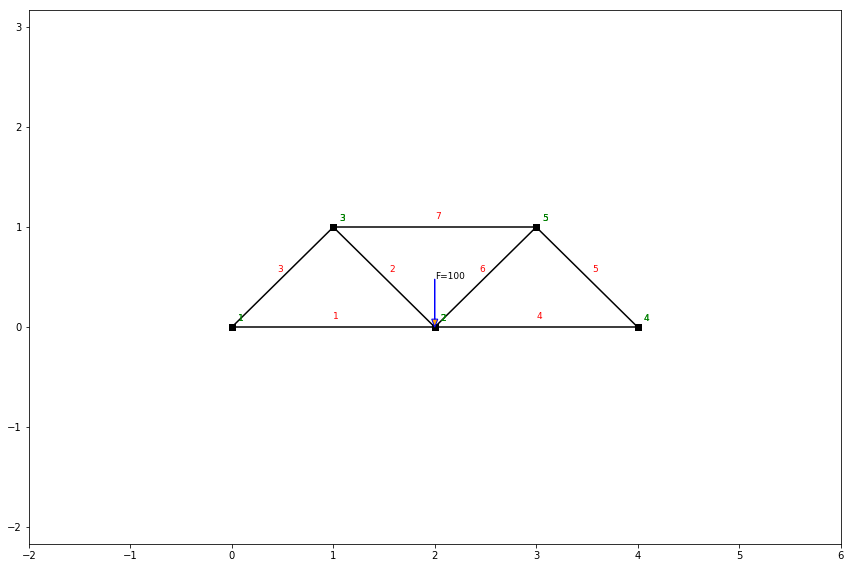

In [48]:
ss = SystemElements()
ss.add_element([2, 0])
ss.add_element([1, 1])
ss.add_element([0, 0])
ss.add_element([[2, 0], [4, 0]])
ss.add_element([[3, 1]])
ss.add_element([[2, 0]])
ss.add_element([[3, 1], [1, 1]])


x_range = ss.nodes_range('x')
length = max(x_range)
middle_node_id = np.argmin(np.abs(np.array(x_range) - length // 2)) + 1

ss.point_load(middle_node_id, Fz=-100)
ss.show_structure()

1.89742038692


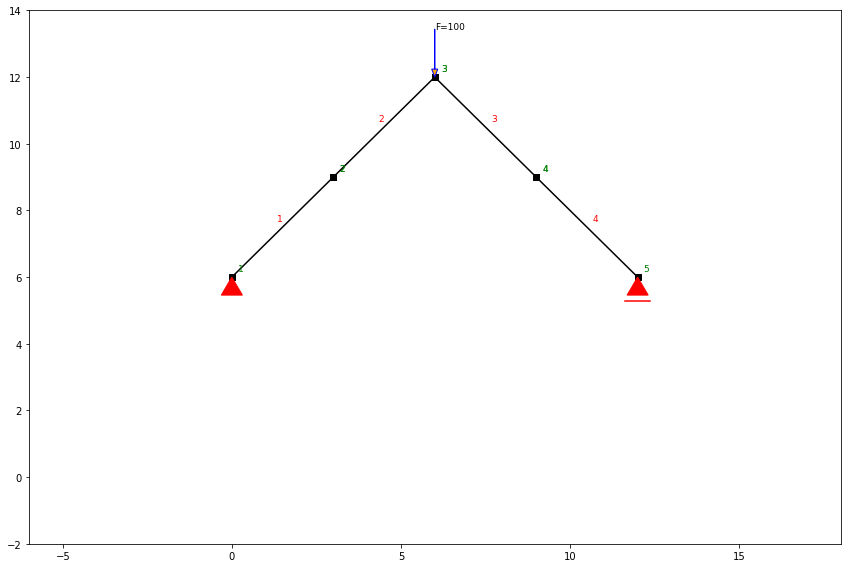

In [62]:
opposite = {
    0:4,
    1:5,
    2:6,
    3:7,
    4:0,
    5:1,
    6:2,
    7:3,
}

def scale_down(x, minimum, maximum):
    """
    Scale the goal location down.
    
    :param x: (array) Location -> rows, collumns
    :param minimum: (int) min(rows, col) -> 0
    :param maximum: (int) max(rows, col)
    
    return: (array) normalized between 0 and 1
    """
    return (x - minimum) / (maximum - minimum)

def scale_up(x, minimum, maximum):
    x * (maximum - minimum) + minimum

class Environment:
    def __init__(self, length=10, height=8, max_steps=12):
        self.length = length
        self.height = height
        self.state = None
        self.location = None
        self.deploy = None
        self.state_count = None # Count the passed states by index (starting from 0)
        # The state index at which the last element was added
        self.last_element_added = None 
        self.last_element_location = None

        # valid actions
        self.no_action = None
        self.action_space = {0, 1, 2, 3, 4, 5, 6, 7, 8}
        self.valid_actions = None
        
        # structure
        self.ss = None
        self.last_step = None
        
        # actions
        self.right = 0
        self.left = 4
        self.up = 2
        self.down = 6
        self.up_right = 1
        self.up_left = 3
        self.down_right = 7
        self.down_left = 5
        
        # If the state is a flattened array. This maps to the index displacements.
        self.move_map = {self.right: np.array([0, 1]),
                         self.left: np.array([0, -1]),
                         self.up: np.array([-1, 0]),
                         self.down: np.array([1, 0]),
                         self.up_right: np.array([-1, 1]),
                         self.up_left: np.array([-1, -1]),
                         self.down_right: np.array([1, 1]),
                         self.down_left: np.array([1, -1])} 
        
        self.max_steps = max_steps - 1
    
    def reset(self):
        self.ss = SystemElements()
        self.last_element_added = -1
        self.last_element_location = np.array(self.location)
        self.state_count = -1
        
        self.built_nodes = set()
        
        self.goal = np.array([self.height // 2, self.length - 1])
        self.location = np.array([self.height // 2, 0])
        
        self.state = np.zeros((self.height, self.length))
        self.state[np.split(self.location, 2)] = 1
        self.det_valid_actions()
        
        return np.concatenate((self.state.ravel(), scale_down(self.location, 0, max(self.height, self.length) - 1), 
                                [scale_down(self.state_count, 0, self.max_steps)]))
    
    def view(self):
        s = np.array(self.state, dtype=object)
        if np.all(self.location == self.goal):
            s[np.split(self.goal, 2)] = "R"
        else:
            s[np.split(self.location, 2)] = "L"
            s[np.split(self.goal, 2)] = "G"
        return s
    
    def return_action(self, r):
        done = False
        
        if self.max_steps == self.state_count:

        # Bridge is build
            r = r + self.compute_reward()
            done = True
            return np.concatenate((self.state.ravel(), 
                                   scale_down(self.location, 0, max(self.height, self.length) -1), 
                                   [scale_down(self.state_count, 0, self.max_steps)])
                                 ), r, done
                    
        self.det_valid_actions()
        if len(self.valid_actions) == 0:
            done = True
            r -= 0.5
        
        return np.concatenate((self.state.ravel(),
                               scale_down(self.location, 0, max(self.height, self.length)),
                             [scale_down(self.state_count, 0, self.max_steps)])), r, done
    
    def det_valid_actions(self):
        no_action = set()
        
        # current location
        row, col = self.location

        # right:
        if col + 3 >= self.length:
            no_action.add(self.right)
            no_action.add(self.up_right)
            no_action.add(self.down_right)
            
        if col <= 2:
            no_action.add(self.left)
            no_action.add(self.up_left)
            no_action.add(self.down_left)
        
        if row <= 2:
            no_action.add(self.up)
            no_action.add(self.up_right)
            no_action.add(self.up_left)
 
        if row >= self.height -3:
            no_action.add(self.down)
            no_action.add(self.down_right)
            no_action.add(self.down_left)
                    
        self.no_action = no_action
        self.valid_actions = list(self.action_space - no_action)
        
    
    def step(self, a):
        """
        :param a: (int) action direction
        
        → 0
        ↗ 1
        ↑ 2
        ↖ 3
        ← 4
        ↙ 5
        ↓ 6
        ↘ 7
        down: 8
        """
        self.last_step = a
        self.state_count += 1

        if a in self.no_action:
            return self.return_action(-0.1)
        
        # make sure there are no double elements
        if int(self.state[np.split(self.location + self.move_map[a], 2)]) == 1:
            self.location += self.move_map[a] * 3 # update location 
            return self.return_action(0)
                
        y1 = self.height - 1 - self.location[0]
        x1 = self.location[1]
        self.state[np.split(self.location + self.move_map[a], 2)] = 1
        self.state[np.split(self.location + self.move_map[a] * 2, 2)] = 1
        self.state[np.split(self.location + self.move_map[a] * 3, 2)] = 1

        self.location += self.move_map[a] * 3

        y2 = self.height - 1 - self.location[0]
        x2 = self.location[1]
        self.ss.add_element([[x1, y1], [x2, y2]])
        self.deploy = 0 # bool
        self.last_element_added = self.state_count
        self.last_element_location = np.array(self.location)

        return self.return_action(0)
    
    def structure(self):
        # last node's x
        x_range = self.ss.nodes_range('x')
        length = max(x_range)
                
        middle_node_id = np.argmin(np.abs(np.array(x_range) - length // 2)) + 1
        max_node_id = np.argmin(np.abs(np.array(x_range) - length)) + 1
        
        self.ss.add_support_hinged(1)
        self.ss.add_support_roll(max_node_id)
        
        self.ss.point_load(middle_node_id, Fz=-100)
        self.ss.solve()
        
        return abs(self.ss.get_node_displacements(middle_node_id)["uy"])
    
    def compute_reward(self):
        length = max(self.ss.nodes_range('x'))
        return 1 / (self.structure() / (100 * length**3 / (48 * self.ss.EI))) + length / 10
    
    def sample_action(self):
        return np.random.randint(0, 9) 
    
    def state_size(self):
        return self.reset().size

    
    """
    :param a: (int) action direction

    → 0
    ↗ 1
    ↑ 2
    ↖ 3
    ← 4
    ↙ 5
    ↓ 6
    ↘ 7
    down: 8
    """
        
env = Environment(13, 13)
env.reset()
env.step(1)
env.step(1)
env.step(7)
env.step(7)
env.view()
print(env.compute_reward())
env.ss.show_structure()


In [59]:
scale_down(env.state_count, 0, env.max_steps)

0.0

In [45]:
# https://theneuralperspective.com/2016/11/25/reinforcement-learning-rl-policy-gradients-i/

def leaky_relu(x, alpha=0.1):
    return tf.maximum(x, alpha * x)

class Agent:
    def __init__(self, data_size, hidden_size, action_space, learning_rate, name):
        """
        :param data_size: (int) Columns of the data vector.
        :param hidden_size: (int) No. of hidden nodes.
        :param action_space: (int) No. of outputs.
        :param learning_rate: (flt)
        """
        
        if len(hidden_size) == 1:
            one_hidden_layer = True
            hidden_size.append(hidden_size[0])
        else:
            one_hidden_layer = False

        
        # Step 1: Feed forward
        # The argmax is the maximum Q-value.
        self.input_s = tf.placeholder(tf.float32, [None, data_size], name="input_s")
        self.w1 = tf.get_variable(f"{name}_w1", shape=[data_size, hidden_size[0]], initializer=tf.contrib.layers.xavier_initializer())
        self.b1 = tf.get_variable(f"{name}_b1", shape=(hidden_size[0], ), initializer=tf.zeros_initializer())
        self.layer_1 = leaky_relu(tf.matmul(self.input_s, self.w1) + self.b1)
        
        self.w2 = tf.get_variable(f"{name}_w2", shape=[hidden_size[0], hidden_size[1]], initializer=tf.contrib.layers.xavier_initializer())
        self.b2 = tf.get_variable(f"{name}_b2", shape=(hidden_size[1], ), initializer=tf.zeros_initializer())
        self.layer_2 = leaky_relu(tf.matmul(self.layer_1, self.w2) + self.b2)
                     
        self.w_out = tf.get_variable(f"{name}_w_out", shape=[hidden_size[1], action_space], initializer=tf.contrib.layers.xavier_initializer())
        self.b_out = tf.get_variable(f"{name}_b_out", shape=(action_space, ), initializer=tf.zeros_initializer())
        
        if one_hidden_layer:
            hidden_layer = self.layer_1
        else:
            hidden_layer = self.layer_2
        
        # argmax(Q(s, a)) 
        self.predict_Q = tf.matmul(hidden_layer, self.w_out) + self.b_out # actual Q-value
        self.Q_a = tf.argmax(self.predict_Q, 1)
        
        # Boltzman exploration
        self.temperature = tf.placeholder(dtype=tf.float32)
        self.p = tf.nn.softmax(self.predict_Q / self.temperature)

        
        # Step 2: Determine loss / gradients. 
        # One hot encoded actions
        self.executed_actions = tf.placeholder(tf.int32)
        
        self.one_hot = tf.one_hot(self.executed_actions, action_space)
        self.Q = tf.reduce_sum(tf.multiply(self.predict_Q, self.one_hot), axis=1)
        self.next_Q_r = tf.placeholder(tf.float32)

         # Loss
         # mse: (     target      -    prediction)^2
         #      r + max(Q(s', a') -    Q(s, a) )^2
        starter_learning_rate = learning_rate
        self.train_count = tf.Variable(0, trainable=False, name=f"{name}_train_count")
        learning_rate = tf.train.exponential_decay(starter_learning_rate, self.train_count,
                                                   10000, 0.96)
    
        self.loss = tf.reduce_sum(tf.square(self.next_Q_r - self.Q))   
        optimizer = tf.train.AdamOptimizer(learning_rate)
        
        self.train = optimizer.minimize(self.loss, self.train_count)
        self.saver = tf.train.Saver()
        
        
        
        

In [46]:
def discounted_reward(r, gamma):
    """
    The reward for a given state. Is the reward for that state + the discounted sum of future rewards.
    
    :param r: (array) Rewards.
    :param gamma: (flt) Discount factor
    """
    return np.cumsum(r * gamma**(np.arange(len(r)))[::-1])[::-1]

def prepare_update_target(trainables, tau=0.05):
    """
    The weights and biases of the target will be a depended of the primary network.
    
    wb[target] = tau * wb[primary] + (1-tau) * wb[target]
    
    This is a tensorflow operation and still needs to be run with Session.run(operation_holder)
    
    :trainables (tf.trainable_variables)
    :tau (flt) Rate to update the target graph
    """
    
    operation_holder = []
    n_variables = len(trainables) // 2 # the agent has half and the target has half
    
    for i, v in enumerate(trainables[0: n_variables]):
        operation_holder.append(trainables[i + n_variables].assign(v.value() * tau) +
                                ((1 - tau) * trainables[i + n_variables].value()))
    return operation_holder

def update_target(operation_holder, session):
    for op in operation_holder:
        session.run(op)
    

In [22]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5614666863836601785, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 1513684992
 locality {
   bus_id: 1
 }
 incarnation: 8171637415570309317
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0"]

In [97]:
count = 0
max_frames = 12
env = Environment(13, 6, max_steps=max_frames)
with tf.device('/gpu:0'):
    from collections import deque    
    env.reset()

    H = [128, 64] # hidden neurons
    D = env.state_size() # input (state of the environment)
    learning_rate = 1e-3
    gamma = 0.99 # discount factor
    epochs = 5000
    buffer_size = 30000

    action_space = 8
    contin = 1

    if not contin:
        eps = 0.1
        temp = 1
        tf.reset_default_graph()
        agent = Agent(D, H, action_space, learning_rate, "agent")
        target = Agent(D, H, action_space, learning_rate, "target")

        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)
        buffer = []
        n_success = 0

        # the first half of the list are the variables of the agent.
        # The last half the variables of the target
        variables = tf.trainable_variables() 
        operation_holder = prepare_update_target(variables)
        scores = list()
        success_buffer = deque()

    last_ep = 0
    train_count = 0
    loss = 0

    for ep in range(epochs):

        if temp > 1 and len(buffer) >= buffer_size:
            temp *= 0.999

        if (ep + 1) % 50 == 0 and len(scores) > 1000:
            print(np.mean(scores[-100:]), "train_count", train_count,
                  "loss", loss, "temp", temp)

            scores = scores[-1000:]

        s = env.reset()
        s = [s]
        
        episode_buffer = []

        for c in range(max_frames):
            count += 1

            p = sess.run(agent.p, {agent.input_s: s, agent.temperature: temp})
            
            if np.random.rand() > 0.01:
#                 a = np.random.choice(p[0], p=p[0])
#            a = np.argmin(np.abs(p[0] - a))
                a = np.argmax(p[0])
            else:
                a = np.random.randint(0, 8)
 


            s_new, r, done = env.step(a)
            if done:
                if not max(env.ss.nodes_range('x')) > 3:
                    r = -1
                scores.append(r)

            buffer.append([s, a, r, s_new, done])
#             episode_buffer.append([s, a, s_new])           
            
            s = [s_new]
            
            if done:
                break
                
        # Hindsight Eperience Replay
        
#         if env.last_element_location is not None and max(env.ss.nodes_range('x')) > 3: # Though very rare. No valid action is taken
#             index = env.last_element_added
#             i = 0

#             goal = scale_down(env.last_element_location, 0, max(env.height, env.length) - 1)
#             while i < index:
#                 i += 1
                
#                 # retreive the states from the episode buffer
#                 s, a, s_new = episode_buffer[i]
#                 s = s[0] # remove redundant brackets
                
#                 # replace the goal in the state with the 'fake' goal
#                 np.put(s, [-2, -1], goal)
#                 np.put(s_new, [-2, -1], goal)
                 
#                 if i == index:
#                     done = True
#                     r = env.compute_reward()                       
                       
#                 else:
#                     done = False
#                     r = 0
                
#                 buffer.append([s, a, r, s_new, done])

#             if len(buffer) > buffer_size:
#                 buffer = buffer[-buffer_size:]
            
        # Train
        if len(buffer) >= 1750 and count % 2 == 0:

            batch = np.vstack(buffer)
            batch = batch[np.random.randint(0, len(buffer), size=150)]

            s_ = np.vstack(batch[:, 0])
            s_new_ = np.vstack(batch[:, 3])
            r_ = batch[:, 2]
            a_ = batch[:, 1]
            done_ = np.array(batch[:, 4], dtype=bool)
            Q = sess.run(agent.predict_Q, {agent.input_s: s_})


            # Double Q-learning primary network chooses an action:
            Q_i = np.argmax(sess.run(agent.predict_Q, {agent.input_s: s_new_}), 1)

            # Target network produces the Q-value of the chosen action
            Q_new = sess.run(target.predict_Q, {target.input_s: s_new_})
            max_Q_new =Q_new[np.arange(Q_i.size)[:, None], Q_i[:, None]][:, -1]

            target_Q = r_ + gamma * max_Q_new
            target_Q[done_] = r_[done_]

            train_count, loss, _ = sess.run([agent.train_count, agent.loss, agent.train], 
                                            feed_dict={agent.input_s: s_, 
                                                       agent.executed_actions: a_, 
                                                       agent.next_Q_r: target_Q})
            if count % 8 == 0:
                # update target network
                update_target(operation_holder, sess)




2.02047742758 train_count 11559 loss 2.1521 temp 0.9996329430800702
2.09714661432 train_count 11609 loss 1.93681 temp 0.9996329430800702
2.09555292429 train_count 11659 loss 0.585576 temp 0.9996329430800702
2.08943449548 train_count 11709 loss 2.62689 temp 0.9996329430800702
2.08927448493 train_count 11759 loss 0.625583 temp 0.9996329430800702
2.09539291374 train_count 11809 loss 1.50928 temp 0.9996329430800702
2.09455292429 train_count 11859 loss 1.60556 temp 0.9996329430800702
2.08686528241 train_count 11909 loss 0.9013 temp 0.9996329430800702
2.09023098725 train_count 11959 loss 1.51348 temp 0.9996329430800702
2.09758950802 train_count 12009 loss 0.879913 temp 0.9996329430800702
2.08864657796 train_count 12059 loss 2.18434 temp 0.9996329430800702
2.08870527186 train_count 12109 loss 0.564764 temp 0.9996329430800702
2.09334553262 train_count 12159 loss 0.83735 temp 0.9996329430800702
2.08557083818 train_count 12209 loss 1.09963 temp 0.9996329430800702


KeyboardInterrupt: 

In [79]:
np.random.rand()

0.49336930430767234

In [270]:
agent.saver.save(sess, 
                 "/home/ritchie46/Dropbox/Code/Python/deep_learning/vanilla/reinforcement_learning/" +
                 "models/model_her/model.ckpt")


'/home/ritchie46/Dropbox/Code/Python/deep_learning/vanilla/reinforcement_learning/models/model_her/model.ckpt'


 [[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 ['L' 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 'G']
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]
[[-0.01052511  0.00853179 -0.0028659  -0.08832489 -0.08375818 -0.10983828
   0.00974163  0.00203545]]
action 6
0 False

 [[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:210: RuntimeWarning: divide by zero encountered in double_scalars


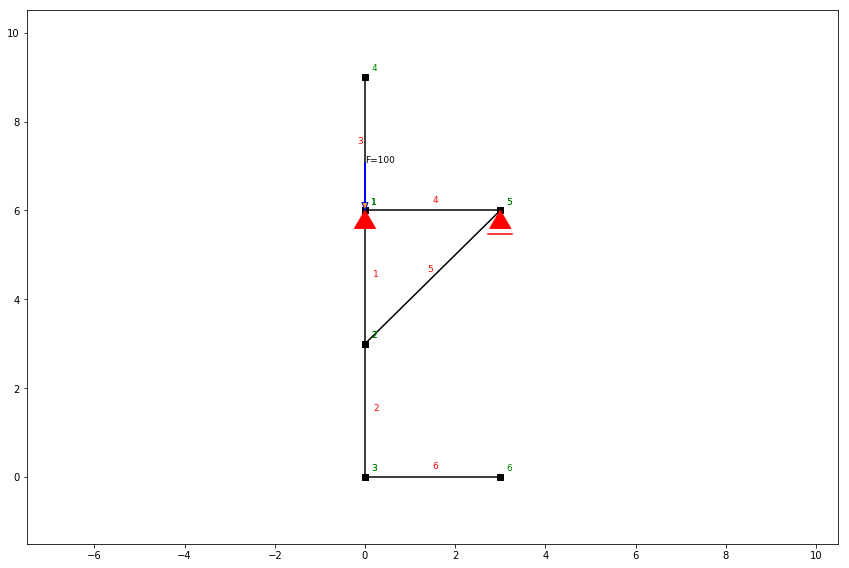

 inf inf


In [98]:
env = Environment(13, 13, 12)
s = env.reset()


"""    
    → 0
    ↗ 1
    ↑ 2
    ↖ 3
    ← 4
    ↙ 5
    ↓ 6
    ↘ 7
"""

bot = agent

total_r = 0

for i in range(12):    
    print("\n", env.view())
    
    a_dst = sess.run(bot.predict_Q, {bot.input_s: [s]})
    print(a_dst)
    
    for j in range(8):
        a = np.argmax(a_dst)
        if a not in env.valid_actions:
            print(f"Needed a {j}th try")
            a_dst[0][a] = - 10
        else:
            break

    
    s, r, d = env.step(a)

    print("action", a)
    print(r, d)
    total_r += r
    
    if d == True:
        env.ss.show_structure()
        break

print("\r", total_r, env.compute_reward())